In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [151]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../scripts/')

from proj1_helpers import *
from implementations import *
from implementation_variants import *
from plots import *

SEED = 42
DATA_PATH = '../data/'

# 0 Load data

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train.set_index('Id')
df_train_x = df_train[list(filter(lambda c: c != 'Prediction', list(df_train)))]

FEATURE_NAMES = list(df_train_x)

In [115]:
 # Load train data
y, x, ids = load_csv_data(path.join(DATA_PATH, 'train.csv'))

# Split into train and evaluation set
(x_train, y_train), (x_eval, y_eval) = train_eval_split(y, x, split_ratio=.7, seed=1)

print(f' # train samples: {len(y_train)}\n # eval samples: {len(y_eval)}')

num_dim = x_train.shape[1]

 # train samples: 175000
 # eval samples: 75000


In [6]:
def generate_mask(features_to_remove):
    feat_idx = [FEATURE_NAMES.index(f) for f in features_to_remove]
    mask = np.ones(len(FEATURE_NAMES)).astype(bool)
    mask[feat_idx] = False
    
    return mask

In [132]:
LEAST_INFO = ['DER_mass_vis', 'DER_deltar_tau_lep','DER_pt_tot','PRI_tau_eta','PRI_tau_phi',
              'PRI_lep_pt','PRI_lep_eta','PRI_lep_phi','PRI_met','PRI_met_phi']

JET_NOT_DEFINED = ['DER_lep_eta_centrality', 'DER_prodeta_jet_jet', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 
                      'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_subleading_pt']

DER_FEATURES = list(filter(lambda c: 'DER' in c, list(FEATURE_NAMES)))

feature_masks = [generate_mask([]), generate_mask(LEAST_INFO), generate_mask(JET_NOT_DEFINED)]

labels = ['Raw', 'MostInfo', 'Jet', 'Impute', 'Indicator']

In [14]:
def compare_features_visualisation(acc_train, acc_test, labels, model):
    arr_train = acc_train.flatten()
    arr_test = acc_test.flatten()

    arr_features = np.concatenate([np.repeat(labels, acc_train.shape[1]), np.repeat(labels, acc_train.shape[1])])
    arr_labels = np.concatenate([np.repeat('Train', len(arr_train)), np.repeat('Test', len(arr_test))])
    arr_acc = np.concatenate([arr_train, arr_test])

    plt_data = pd.DataFrame({'Feature Set':arr_features, 'Accuracy':arr_acc, 'Set':arr_labels})

    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.boxplot(x='Feature Set', y='Accuracy', hue='Set', data=plt_data)
    ax.set(ylabel='$\mathtt{Accuracy}$', title=f'{model}');
    
    return fig

# 1 Least-Squares

In [95]:
def run_least_squares(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    # Run training
    w, loss = least_squares(y_train, x_train)
#     print(f'Training loss: {loss}')

    # Get training accuracy
    acc_tr  = eval_model(y_train, x_train, w, thresh=0)
#     print(f'Training accuracy: {acc_tr}')

    # Get accuracy on evaluation set
    acc_te = eval_model(y_eval, x_eval, w, thresh=0)
    print(f'Test Accuracy: {acc_te}')
    
    return w, loss, acc_tr, acc_te

Feature Set:  Raw
Test Accuracy: 0.7192457142857143
Test Accuracy: 0.7175542857142857
Test Accuracy: 0.7191314285714285
Test Accuracy: 0.7180342857142857
Feature Set:  MostInfo
Test Accuracy: 0.7092114285714286
Test Accuracy: 0.7069485714285715
Test Accuracy: 0.7116114285714286
Test Accuracy: 0.7067885714285714
Feature Set:  Jet
Test Accuracy: 0.7086628571428571
Test Accuracy: 0.7079771428571429
Test Accuracy: 0.7071085714285714
Test Accuracy: 0.7056685714285714
Feature Set: Impute
Test Accuracy: 0.71952
Test Accuracy: 0.7175542857142857
Test Accuracy: 0.7188571428571429
Test Accuracy: 0.7179428571428571
Feature Set: Indicator
Test Accuracy: 0.7205714285714285
Test Accuracy: 0.7192685714285715
Test Accuracy: 0.7202514285714285
Test Accuracy: 0.7194514285714285


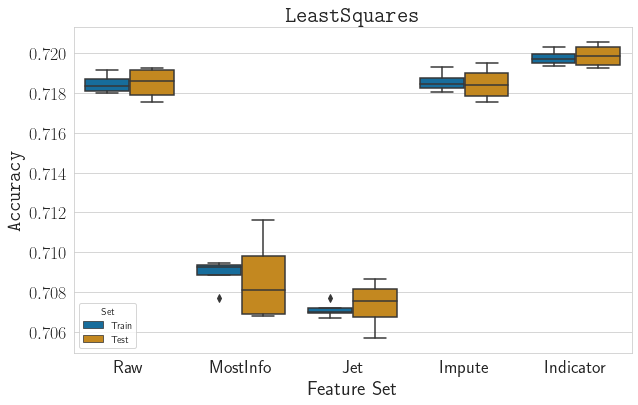

In [143]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(feature_masks)+2, k_fold), float)
acc_test = np.empty((len(feature_masks)+2, k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('Feature Set: ', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('Feature Set: Impute')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('Feature Set: Indicator')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{LeastSquares}$')
fig.savefig('../report/compare_features_ls.pdf', bbox_inches='tight')

# 2 Ridge Regresion

In [146]:
def run_ridge(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    lambdas = np.logspace(-8, -1, 10)
    k_fold = 4

    # Hyperparameter optimisation
    acc_train = np.empty((len(lambdas), k_fold), float)
    acc_test = np.empty((len(lambdas), k_fold), float)

    for l, lambda_ in enumerate(lambdas):
        k = 0
        for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Train
            w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
            acc_tr = eval_model(train_split[1], train_split[0], w)
            acc_train[l, k] = acc_tr

            # Test
            acc_te = eval_model(test_split[1], test_split[0], w)
            acc_test[l, k] = acc_te

            k += 1
#     fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

    avg_acc_test = np.mean(acc_test, axis=1)
    lambda_opt_ridge = lambdas[np.argmax(avg_acc_test)]

    print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt_ridge))
    
    # Run training
    w, loss = ridge_regression(y_train, x_train, lambda_opt_ridge)
#     print(f'Training loss: {loss_ridge}')

    acc_tr = eval_model(y_train, x_train, w)
#     print(f'Training accuracy: {acc}')

    acc_te = eval_model(y_eval, x_eval, w)
    print(f'Test accuracy: {acc_te}')
    
    
    return w, loss, acc_tr, acc_te
    

Feature Set Raw
Maximum test accuracy 0.7186928562720956 with lambda 5.99484250318941e-08
Test accuracy: 0.7196342857142857
Maximum test accuracy 0.7184947580153602 with lambda 1e-08
Test accuracy: 0.7175314285714286
Maximum test accuracy 0.7182966597586249 with lambda 1e-08
Test accuracy: 0.7194742857142857
Maximum test accuracy 0.7182357064488601 with lambda 3.5938136638046254e-07
Test accuracy: 0.71792
Feature Set MostInfo
Maximum test accuracy 0.7093212848957698 with lambda 5.99484250318941e-08
Test accuracy: 0.7092114285714286
Maximum test accuracy 0.7091612824576374 with lambda 5.99484250318941e-08
Test accuracy: 0.7069257142857143
Maximum test accuracy 0.7077898329879312 with lambda 1e-08
Test accuracy: 0.71168
Maximum test accuracy 0.7090850908204315 with lambda 1e-08
Test accuracy: 0.7068342857142857
Feature Set Jet
Maximum test accuracy 0.7073936364744604 with lambda 1e-08
Test accuracy: 0.7084114285714286
Maximum test accuracy 0.7066164817749604 with lambda 7.742636826811278

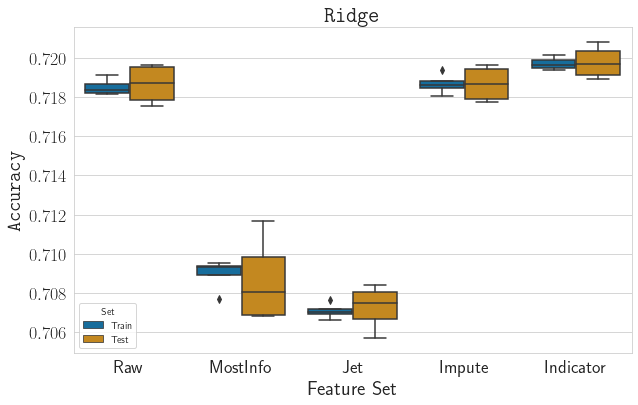

In [147]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(labels), k_fold), float)
acc_test = np.empty((len(labels), k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('\nFeature Set', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('\nFeature Set: Impute')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('\nFeature Set: Indicator')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{Ridge}$')
fig.savefig('../report/compare_features_ridge.pdf', bbox_inches='tight')

# 3 Logistic Regression

In [162]:
def run_logistic(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)

    tx_train = np.c_[np.ones(x_train.shape[0]), x_train]
    tx_eval = np.c_[np.ones(x_eval.shape[0]), x_eval]
    
    gamma = 2e-5
    max_iters = 10000
    w_initial = np.zeros(tx_train.shape[1])

    # Run gradient descent 
    w, loss = logistic_regression_mean(y_train, tx_train, w_initial, max_iters, gamma, threshold=1e-6)
#     print(f'Training loss: {loss_lr}')

    acc_tr = eval_model(y_train, tx_train, w, thresh=0.5)
#     print(f'Training accuracy: {acc}')

    acc_te = eval_model(y_eval, tx_eval, w, thresh=0.5)
    print(f'Testing accuracy: {acc_te}')
    
    return w, loss, acc_tr, acc_te

Feature Set:  Raw
Testing accuracy: 0.6612114285714286
Testing accuracy: 0.6580114285714286
Testing accuracy: 0.6564342857142857
Testing accuracy: 0.6564342857142857
Feature Set:  MostInfo
Testing accuracy: 0.6612342857142857
Testing accuracy: 0.6580571428571429
Testing accuracy: 0.6565942857142857
Testing accuracy: 0.6565028571428572
Feature Set:  Jet
Testing accuracy: 0.66112
Testing accuracy: 0.6581257142857143
Testing accuracy: 0.65632
Testing accuracy: 0.6560228571428571
Feature Set: Impute
Testing accuracy: 0.6616685714285714
Testing accuracy: 0.6584685714285714
Testing accuracy: 0.65664
Testing accuracy: 0.6569142857142857
Feature Set: Indicator
Testing accuracy: 0.6611885714285715
Testing accuracy: 0.6580342857142857
Testing accuracy: 0.6564342857142857
Testing accuracy: 0.6563885714285714


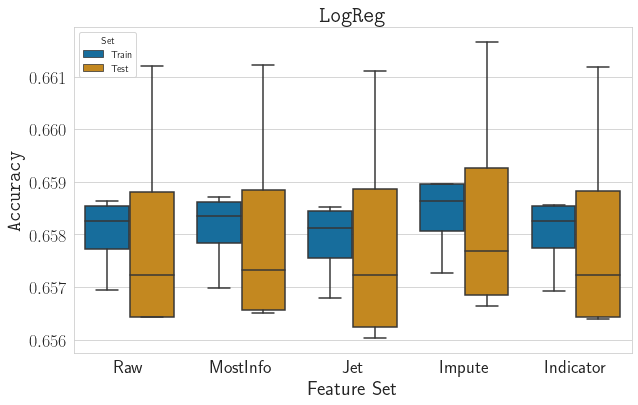

In [163]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(feature_masks)+2, k_fold), float)
acc_test = np.empty((len(feature_masks)+2, k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('Feature Set: ', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('Feature Set: Impute')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('Feature Set: Indicator')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{LogReg}$')
fig.savefig('../report/compare_features_logreg.pdf', bbox_inches='tight')

# -------------

# Compare model performance on best performing feature set 

##### Data Processing

In [172]:
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

def feature_transform(x):
    x_ind = (x[:, JET_NUM_IDX] > 1).astype(int)
    x = np.concatenate([x, np.expand_dims(x_ind, axis=1)], axis=1)

    features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
    features = np.concatenate([features, [True]])

    x = x[:, features]
    
    return x

fx_train = feature_transform(x_train)
fx_eval = feature_transform(x_eval)

fx_train, mu_x, sigma_x = standardise(fx_train)
fx_eval = standardise_to_fixed(fx_eval, mu_x, sigma_x)

tx_train = np.c_[np.ones(fx_train.shape[0]), fx_train]
tx_eval = np.c_[np.ones(fx_eval.shape[0]), fx_eval]

##### Train LogReg

In [ ]:
# Run cross-validation to find optimal step-size
gammas = np.logspace(-7, -2, 5)
k_fold = 4

max_iters = 5000
w_initial = np.ones(tx_train.shape[1])

# Hyperparameter optimisation
acc_train = np.empty((len(gammas), k_fold), float)
acc_test = np.empty((len(gammas), k_fold), float)

for g, gamma in enumerate(gammas):
    k = 0
    for train_split, test_split in k_fold_iter(y_train, tx_train, k_fold):
        # Train
        w, loss = logistic_regression_mean(train_split[1], train_split[0], w_initial, 
                                           max_iters, gamma, threshold=1e-6, verbose=False)
        
        acc_tr = eval_model(train_split[1], train_split[0], w, thresh=0.5)
        acc_train[g, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w, thresh=0.5)
        acc_test[g, k] = acc_te

        k += 1

Loss convergence:Terminate because loss did not change by more than threshold.
Loss convergence:Terminate because loss did not change by more than threshold.
Loss convergence:Terminate because loss did not change by more than threshold.
Loss convergence:Terminate because loss did not change by more than threshold.


In [ ]:
fig = cross_validation_visualization(gammas, 1-acc_train, 1-acc_test)

avg_acc_test = np.mean(acc_test, axis=1)
gamma_opt_lr = gammas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with gamma {}'.format(np.max(avg_acc_test), gamma_opt_lr))

# 3 Add indicator

In [221]:
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

def add_jet_indicator(y_train, x_train, y_eval, x_eval):
    x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
    x_train = np.delete(x_train, JET_NUM_IDX, axis=1)
    x_train = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)
    
    x_ind = (x_eval[:, JET_NUM_IDX] > 1).astype(int)
    x_eval = np.delete(x_eval, JET_NUM_IDX, axis=1)
    x_eval = np.concatenate([x_eval, np.expand_dims(x_ind, axis=1)], axis=1)
    
    # Standardise
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    print('--Least Squares--')
    w_mi, acc_mi = run_least_squares(y_train, x_train, y_eval, x_eval)
    
    print('\n--Ridge--')
    w_mi, acc_mi, lambda_mi = run_ridge(y_train, x_train, y_eval, x_eval)

--Least Squares--
Training loss: 0.14292444720539205
Training accuracy: 0.7184
Test Accuracy: 0.7198933333333334

--Ridge--
lambda: 1e-09
lambda: 4.393970560760786e-09
lambda: 1.9306977288832496e-08
lambda: 8.483428982440726e-08
lambda: 3.727593720314938e-07
lambda: 1.6378937069540647e-06
lambda: 7.196856730011529e-06
lambda: 3.1622776601683795e-05
lambda: 0.0001389495494373139
lambda: 0.0006105402296585339
lambda: 0.002682695795279727
lambda: 0.01178768634793589
lambda: 0.05179474679231223
lambda: 0.2275845926074791
lambda: 1.0
Maximum test accuracy 0.7182857142857143 with lambda 4.393970560760786e-09
Training loss: 0.1429301352985215
Training accuracy: 0.71832
Test accuracy: 0.7198


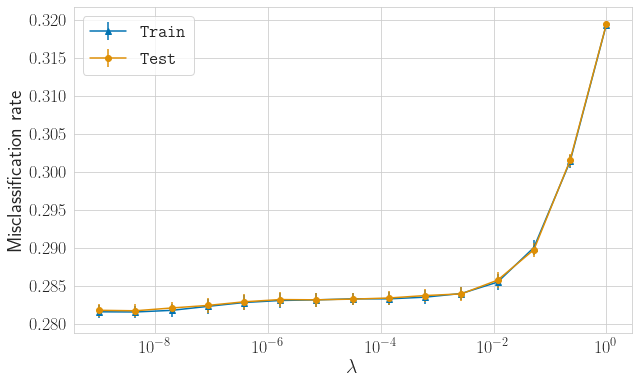

In [222]:
add_jet_indicator(y_train, x_train, y_eval, x_eval)